#Physics Informed Neural Networks for Option Pricing


\\

This is a Jupyter notebook that introduces Physics Informed Neural Networks, and then later uses them to solve various Partial Differential Equations. We shall be using PyTorch for this implementation, but this can equally well be done using Keras/Tensorflow.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import imageio
import io

Construct the Neural Netwrok Architecture as a fully-connected, feed-forward Neural Network

In [ ]:
class FCNN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.net = nn.Sequential()
        for i in range(len(layers)-2):
            self.net.add_module(f"lin{i}", nn.Linear(layers[i], layers[i+1]))
            self.net.add_module(f"act{i}", nn.Tanh())
        self.net.add_module("out", nn.Linear(layers[-2], layers[-1]))

    def forward(self, x):
        return self.net(x)

The 1-D Damped Harmonic Oscillator

In [ ]:
# Analytical solution for underdamped damped harmonic oscillator
def analytic_solution(t, c, k, u0, v0):
    d = c / 2
    omega0 = np.sqrt(k)
    wd = np.sqrt(omega0**2 - d**2)
    A = u0
    B = (v0 + d * u0) / wd
    return np.exp(-d * t) * (A * np.cos(wd * t) + B * np.sin(wd * t))


### PINN for the damped harmonic oscillator

In [ ]:
# PINN training for u'' + c*u' + k*u = 0
def train_pinn(c, k, u0, v0, T, layers, epochs=5000, N_f=2000, lr=1e-3):
    model = FCNN(layers)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()

    for epoch in range(epochs):
        # Collocation points in [0, T]
        t_f = torch.rand(N_f,1) * T
        t_f.requires_grad_(True)

        # PDE residual
        u = model(t_f)
        u_t = torch.autograd.grad(u, t_f, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_tt = torch.autograd.grad(u_t, t_f, grad_outputs=torch.ones_like(u_t), create_graph=True)[0]
        f = u_tt + c * u_t + k * u

        # Initial condition at t=0
        t0 = torch.zeros((1,1), requires_grad=True)
        u0_pred = model(t0)
        u_t0_pred = torch.autograd.grad(u0_pred, t0, grad_outputs=torch.ones_like(u0_pred), create_graph=True)[0]

        loss = mse(f, torch.zeros_like(f)) \
             + mse(u0_pred, torch.tensor([[u0]], dtype=torch.float32)) \
             + mse(u_t0_pred, torch.tensor([[v0]], dtype=torch.float32))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return model

In [ ]:


def train_pinn_gif_fixed_pts(c, k, u0, v0, T, layers,
                             epochs, N_f, lr=1e-3, frame_interval=100):
    # 1) Prepare your **fixed** grids **once**:
    t_grid = np.linspace(0, T, 200)
    t_grid_tensor = torch.tensor(t_grid, dtype=torch.float32).view(-1,1)
    u_true = analytic_solution(t_grid, c, k, u0, v0)

    # 2) Sample **one** set of collocation points *before* training:
    t_f = torch.rand(N_f,1) * T
    t_f.requires_grad_(True)
    # keep a small subset (200) for plotting:
    plot_tf = t_f[:100].detach().cpu().numpy().flatten()

    # 3) IC point
    t_ic = torch.zeros((1,1), requires_grad=True)
    u_ic = torch.tensor([[u0]], dtype=torch.float32)

    model     = FCNN(layers)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    mse       = nn.MSELoss()

    frames = []
    for epoch in range(1, epochs+1):
        # -- compute PINN loss on the same t_f every epoch --
        u    = model(t_f)
        u_t  = torch.autograd.grad(u, t_f,
                   grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_tt = torch.autograd.grad(u_t, t_f,
                   grad_outputs=torch.ones_like(u_t), create_graph=True)[0]
        f    = u_tt + c * u_t + k * u

        u0_pred   = model(t_ic)
        u_t0_pred = torch.autograd.grad(u0_pred, t_ic,
                       grad_outputs=torch.ones_like(u0_pred), create_graph=True)[0]

        loss = (
            mse(f, torch.zeros_like(f))
          + mse(u0_pred, u_ic)
          + mse(u_t0_pred, torch.tensor([[v0]]))
        )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # -- snapshot frame --
        if epoch % frame_interval == 0 or epoch in (1, epochs):
            with torch.no_grad():
                u_pred_grid = model(t_grid_tensor).detach().cpu().numpy().flatten()

            fig, ax = plt.subplots(figsize=(12, 8), dpi=300)
            ax.plot(t_grid, u_true, label="Analytic", linestyle='--', color='gray')
            ax.plot(t_grid, u_pred_grid, label="PINN")

            # plot fixed collocation locations at y=0
            ax.scatter(plot_tf,
                       np.zeros_like(plot_tf),
                       marker='o', color='red', alpha=0.2,
                       label='Collocation pts')

            # initial-condition point
            ax.scatter(0.0, u0, marker='o', color='green', label='IC')

            ax.set_xlabel("$t$", fontsize=18)
            ax.set_ylabel("$u(t)$", fontsize=18)
            ax.set_title(f"Epoch {epoch}/{epochs} —  Training Loss: {loss.item():.2e}", fontsize=18)
            ax.legend(loc="upper right")

            buf = io.BytesIO()
            fig.savefig(buf, format='png', dpi=300)
            buf.seek(0)
            frames.append(imageio.v2.imread(buf))
            plt.close(fig)

    gif_path = "pinn_fixed_collocation.gif"
    imageio.mimsave(gif_path, frames, fps=5)
    return gif_path

# Usage
if __name__ == "__main__":
    gif = train_pinn_gif_fixed_pts(
        c=0.5, k=4.0, u0=1.0, v0=0.0, T=7.0,
        layers=[1,50,50,50, 1],
        epochs=10000, N_f=4000, lr=1e-3, frame_interval=100
    )
    print("Saved:", gif)

### Traditional Neural Network

In [ ]:
def train_NN_gif_supervised(c, k, u0, v0, T, layers,
                            epochs, N_train,
                            lr, frame_interval):
    # 1) Prepare your **fixed** grids **once**:
    t_grid = np.linspace(0, T, 300)
    t_grid_tensor = torch.tensor(t_grid, dtype=torch.float32).view(-1,1)
    u_true = analytic_solution(t_grid, c, k, u0, v0)

    # 2) Sample a fixed training set once
    t_train = torch.rand(N_train,1) * 2
    u_train = torch.tensor(
        analytic_solution(t_train.detach().numpy().flatten(), c, k, u0, v0),
        dtype=torch.float32
    ).view(-1,1)

    model     = FCNN(layers)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    mse       = nn.MSELoss()
    frames    = []

    for epoch in range(1, epochs+1):
        # Supervised loss on the training set
        model.train()
        pred_train = model(t_train)
        loss = mse(pred_train, u_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Capture GIF frame
        if epoch % frame_interval == 0 or epoch in (1, epochs):
            model.eval()
            with torch.no_grad():
                u_pred = model(t_grid_tensor).cpu().numpy().flatten()

            fig, ax = plt.subplots(figsize=(12, 8), dpi=150)
            ax.plot(t_grid, u_true, linestyle='--', color='gray', label="Analytic")
            ax.plot(t_grid, u_pred,         label="NN Prediction")

            # Overlay the fixed training points
            tt = t_train.cpu().numpy().flatten()
            uu = u_train.cpu().numpy().flatten()
            ax.scatter(tt, uu, marker='o', color='red', alpha=0.5,
                       label="Training Data")

            ax.set_xlabel("$t$", fontsize=18)
            ax.set_ylabel("$u(t)$", fontsize=18)
            ax.set_title(f"Epoch {epoch}/{epochs}  —  Training Loss: {loss.item():.2e}", fontsize=18)
            ax.legend(loc="upper right")

            buf = io.BytesIO()
            fig.savefig(buf, format='png')
            buf.seek(0)
            frames.append(imageio.v2.imread(buf))
            plt.close(fig)

    gif_path = "NN_training.gif"
    imageio.mimsave(gif_path, frames, fps=5)
    return gif_path

if __name__ == "__main__":
    gif_file = train_NN_gif_supervised(
        c=0.5, k=4.0, u0=1.0, v0=0.0, T=7.0,
        layers=[1, 50, 50, 50, 1],
        epochs=10000, N_train=200,
        lr=1e-3, frame_interval=100
    )
    print(f"Saved GIF to {gif_file}")

## Heat Equation


In [ ]:

# 2) PINN setup
class FCNN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.net = nn.Sequential()
        for i in range(len(layers)-2):
            self.net.add_module(f"lin{i}", nn.Linear(layers[i], layers[i+1]))
            self.net.add_module(f"act{i}", nn.Tanh())
        self.net.add_module("out", nn.Linear(layers[-2], layers[-1]))
    def forward(self, x):
        return self.net(x)

In [ ]:
# 1) Exact solution and IC/BC
def u_exact(x, t, alpha):
    return np.exp(-np.pi**2 * alpha * t) * np.sin(np.pi * x)


In [ ]:
def train_pinn(alpha, T, layers, N_f=20000, N_ic=200, N_bc=200,
               epochs=5000, lr=1e-3):
    model = FCNN(layers)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()

    # sample IC points (x,0)
    x_ic = torch.rand(N_ic,1)
    t_ic = torch.zeros_like(x_ic)
    u_ic = torch.sin(np.pi * x_ic)

    # sample BC points at x=0 and x=1
    t_bc = torch.rand(N_bc,1) * T
    x_bc0 = torch.zeros_like(t_bc)
    x_bc1 = torch.ones_like(t_bc)

    for ep in range(1, epochs+1):
        # collocation points in (x,t) domain
        x_f = torch.rand(N_f,1)
        t_f = torch.rand(N_f,1) * T
        x_f.requires_grad_(True)
        t_f.requires_grad_(True)

        # PDE residual u_t - alpha u_xx
        u = model(torch.cat([x_f, t_f], dim=1))
        u_t = torch.autograd.grad(u, t_f,
                  grad_outputs=torch.ones_like(u),
                  create_graph=True)[0]
        u_x = torch.autograd.grad(u, x_f,
                  grad_outputs=torch.ones_like(u),
                  create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x_f,
                  grad_outputs=torch.ones_like(u_x),
                  create_graph=True)[0]
        f_pde = u_t - alpha * u_xx

        # IC loss
        u0_pred = model(torch.cat([x_ic, t_ic], dim=1))
        loss_ic = mse(u0_pred, u_ic)

        # BC loss
        ubc0 = model(torch.cat([x_bc0, t_bc], dim=1))
        ubc1 = model(torch.cat([x_bc1, t_bc], dim=1))
        loss_bc = mse(ubc0, torch.zeros_like(ubc0)) \
                + mse(ubc1, torch.zeros_like(ubc1))

        # PDE loss
        loss_pde = mse(f_pde, torch.zeros_like(f_pde))

        loss = loss_pde + loss_ic + loss_bc
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if ep % 1000 == 0:
            print(f"Epoch {ep:4d} | Loss: {loss.item():.3e}")

    return model

In [ ]:
def crank_nicolson(alpha, T, nx=100, nt=500):
    dx = 1.0/nx
    dt = T/nt
    r = alpha * dt / (2*dx*dx)

    # Build CN matrix A u^{n+1} = B u^n
    main = (1 + 2*r) * np.ones(nx-1)
    off  = -r * np.ones(nx-2)
    A = np.diag(main) + np.diag(off,1) + np.diag(off,-1)
    B = np.diag(1-2*r) * np.ones((nx-1,nx-1)) + \
        np.diag(r*np.ones(nx-2),1) + np.diag(r*np.ones(nx-2),-1)

    # initial condition
    u = np.sin(np.pi * np.linspace(dx,1-dx,nx-1))
    for n in range(nt):
        u = np.linalg.solve(A, B.dot(u))
    # add BC=0 at x=0 and x=1
    return np.concatenate([[0], u, [0]]), dx


Epoch 1000 | Loss: 2.210e-03
Epoch 2000 | Loss: 6.246e-05
Epoch 3000 | Loss: 8.459e-04
Epoch 4000 | Loss: 1.067e-05
Epoch 5000 | Loss: 7.750e-06

L2 error PINN:          6.631e-04


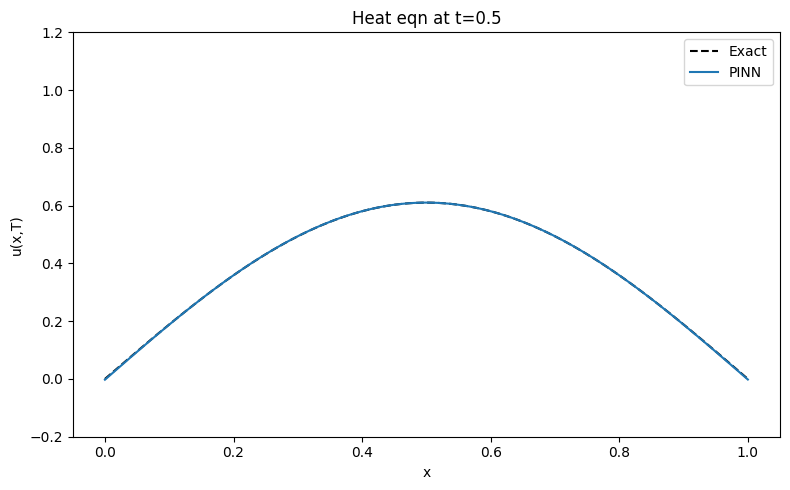

In [ ]:

alpha = 0.1
T = 0.5

# — PINN training —
pinn = train_pinn(alpha, T,
                    layers=[2, 64, 64, 32, 1],
                    epochs=5000, lr=1e-3)
# evaluate PINN
x_plot = np.linspace(0,1,200)
t_plot = T * np.ones_like(x_plot)
with torch.no_grad():
    inp = torch.tensor(np.stack([x_plot, t_plot],1),
                        dtype=torch.float32)
    u_pinn = pinn(inp).numpy().flatten()

# — Crank–Nicolson —
#u_cn, dx = crank_nicolson(alpha, T, nx=200, nt=2000)

# — Exact solution —
x_full = np.linspace(0,1,200)
u_ex = u_exact(x_full, T, alpha)

# — Compute L2 errors —
err_pinn = np.linalg.norm(u_pinn - u_ex, 2) * np.sqrt(1/len(u_ex))
# align CN grid (nx+1=201 points) to 200: drop last
#err_cn   = np.linalg.norm(u_cn[:-1] - u_ex, 2) * np.sqrt(1/len(u_ex))

print(f"\nL2 error PINN:          {err_pinn:.3e}")
#print(f"L2 error Crank–Nicolson: {err_cn:.3e}\n")

# — Plot comparison —
plt.figure(figsize=(8,5))
plt.plot(x_full, u_ex,  'k--',  label="Exact")
plt.plot(x_full, u_pinn, 'C0-',  label="PINN")
#plt.plot(np.linspace(0,1,len(u_cn)), u_cn, 'C1-.', label="Crank–Nicolson")
plt.xlabel("x"); plt.ylabel("u(x,T)")
plt.title(f"Heat eqn at t={T}")
plt.ylim(-0.2,1.2)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
alpha = 0.1
T     = 0.5
x_plot = np.linspace(0, 1, 200)

# 3) choose time‐steps for animation:
n_frames = 100
t_seq = np.linspace(0, T, n_frames)

frames = []
for t in t_seq:
    # PINN prediction at time t
    xt = np.stack([x_plot, t*np.ones_like(x_plot)], axis=1)
    with torch.no_grad():
        u_pred = pinn(torch.tensor(xt, dtype=torch.float32)).numpy().flatten()

    # analytic
    u_ex = u_exact(x_plot, t, alpha)
    error = np.linalg.norm(u_pred - u_ex) * np.sqrt(1/len(u_ex))

    # plot
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(x_plot, u_ex, 'k--', label='Exact')
    ax.plot(x_plot, u_pred, 'C0-', label='PINN', linewidth=2)
    ax.set_title(f"t = {t:.3f}, L2 error = {error:.2e}")
    ax.set_xlabel('x'); ax.set_ylabel('u(x,t)')
    ax.set_ylim(-0.3,1.1)
    ax.legend()

    # capture
    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=100)
    buf.seek(0)
    frames.append(imageio.v2.imread(buf))
    plt.close(fig)

# 4) write GIF
gif_name = 'heat_pinn_animation.gif'
imageio.mimsave(gif_name, frames, fps=15)
print(f"Saved → {gif_name}")

Saved → heat_pinn_animation.gif


In [ ]:
# 2) Build spatial and temporal grids
Nx = 200
Nt = 100
x_plot = np.linspace(0, 1, Nx)
t_seq = np.linspace(0, T, Nt)
X, Tgrid = np.meshgrid(x_plot, t_seq)

# 3) Evaluate PINN on full grid
with torch.no_grad():
    inp = torch.tensor(np.stack([X.flatten(), Tgrid.flatten()], axis=1), dtype=torch.float32)
    U_pred = pinn(inp).numpy().reshape(Nt, Nx)

# 4) Evaluate exact solution on full grid
U_exact = u_exact(X, Tgrid, alpha)

# 5) Set global color limits
vmin = min(U_exact.min(), U_pred.min())
vmax = max(U_exact.max(), U_pred.max())

# 6) Create frames for the heatmap GIF
frames = []
for i in range(Nt):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

    # PINN Heatmap
    im0 = axs[0].imshow(
        U_pred[:i+1, :],
        extent=[0, 1, 0, t_seq[i]],
        origin='lower',
        aspect='auto',
        vmin=vmin,
        vmax=vmax
    )
    axs[0].set_title("PINN Prediction")
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("t")

    # Exact Heatmap
    im1 = axs[1].imshow(
        U_exact[:i+1, :],
        extent=[0, 1, 0, t_seq[i]],
        origin='lower',
        aspect='auto',
        vmin=vmin,
        vmax=vmax
    )
    axs[1].set_title("Exact Solution")
    axs[1].set_xlabel("x")
    axs[1].set_ylabel("t")

    # Shared colorbar
    fig.colorbar(im1, ax=axs, orientation='horizontal', fraction=0.05, pad=0.1)
    fig.suptitle(f"Spatiotemporal Heatmap up to t = {t_seq[i]:.3f}")

    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    frames.append(imageio.v2.imread(buf))
    plt.close(fig)

# 7) Save as GIF
gif_name = "heat_pinn_heatmap.gif"
imageio.mimsave(gif_name, frames, fps=10)
print(f"Saved heatmap animation as {gif_name}")

## Black-Scholes Equation


Epoch 1/10000 - Loss: 2.885e+04
Epoch 200/10000 - Loss: 2.242e+04
Epoch 400/10000 - Loss: 1.817e+04
Epoch 600/10000 - Loss: 1.471e+04
Epoch 800/10000 - Loss: 1.184e+04
Epoch 1000/10000 - Loss: 9.456e+03
Epoch 1200/10000 - Loss: 7.479e+03
Epoch 1400/10000 - Loss: 5.851e+03
Epoch 1600/10000 - Loss: 4.522e+03
Epoch 1800/10000 - Loss: 3.444e+03
Epoch 2000/10000 - Loss: 2.581e+03
Epoch 2200/10000 - Loss: 1.901e+03
Epoch 2400/10000 - Loss: 1.375e+03
Epoch 2600/10000 - Loss: 1.000e+03
Epoch 2800/10000 - Loss: 6.814e+02
Epoch 3000/10000 - Loss: 4.625e+02
Epoch 3200/10000 - Loss: 3.090e+02
Epoch 3400/10000 - Loss: 2.045e+02
Epoch 3600/10000 - Loss: 1.468e+02
Epoch 3800/10000 - Loss: 9.227e+01
Epoch 4000/10000 - Loss: 6.095e+01
Epoch 4200/10000 - Loss: 4.343e+01
Epoch 4400/10000 - Loss: 3.127e+01
Epoch 4600/10000 - Loss: 2.510e+01
Epoch 4800/10000 - Loss: 1.577e+01
Epoch 5000/10000 - Loss: 1.161e+01
Epoch 5200/10000 - Loss: 7.583e+00
Epoch 5400/10000 - Loss: 5.879e+00
Epoch 5600/10000 - Loss: 3.

<ipython-input-46-9074c080f6b0>:7: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))


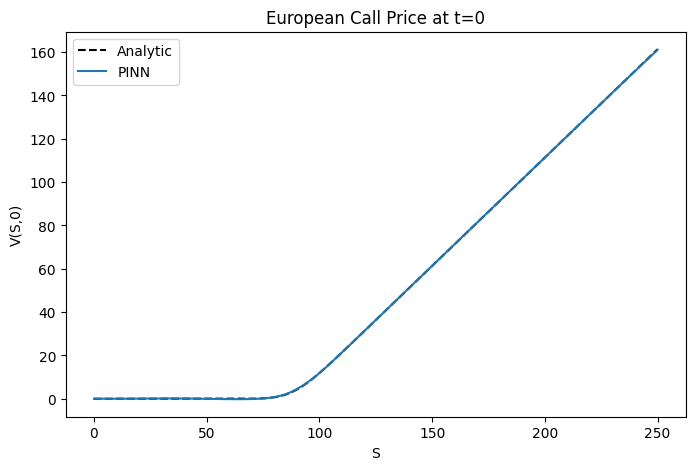

In [ ]:
from scipy.stats import norm


# 1) Analytic Black‑Scholes formula for a European Call
def bs_call_analytic(S, t, K, r, sigma, T):
    tau = np.maximum(T - t, 1e-8)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    return S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)

# 2) PINN network definition
class FCNN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        seq = []
        for i in range(len(layers) - 2):
            seq += [nn.Linear(layers[i], layers[i+1]), nn.Tanh()]
        seq += [nn.Linear(layers[-2], layers[-1])]
        self.net = nn.Sequential(*seq)

    def forward(self, x):
        return self.net(x)

# 3) Corrected training function for the Black‑Scholes PINN
def train_pinn_bs(K, r, sigma, T, S_max, layers,
                  N_f, N_t, N_bc,
                  epochs, lr=1e-3, print_every=200):
    model = FCNN(layers)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()

    # Collocation points in (S, t)
    S_f = torch.rand(N_f,1) * S_max
    t_f = torch.rand(N_f,1) * T
    S_f.requires_grad_(True)
    t_f.requires_grad_(True)

    # Terminal payoff at t = T
    S_T = torch.rand(N_t,1) * S_max
    t_T = T * torch.ones_like(S_T)
    payoff_T = torch.maximum(S_T - K, torch.zeros_like(S_T))

    # Boundary conditions at S=0 and S=S_max
    t_bc = torch.rand(N_bc,1) * T
    S_bc0 = torch.zeros_like(t_bc)
    S_bc1 = S_max * torch.ones_like(t_bc)
    V_bc0 = torch.zeros_like(t_bc)  # V(0, t) = 0
    V_bc1 = S_max - K * torch.exp(-r * (T - t_bc))  # V(S_max, t)

    for ep in range(1, epochs+1):
        # PDE residual: V_t + ½ σ² S² V_SS + r S V_S - r V = 0
        inp_f = torch.cat([S_f, t_f], dim=1)
        V_pred = model(inp_f)
        V_t = torch.autograd.grad(V_pred, t_f, grad_outputs=torch.ones_like(V_pred), create_graph=True)[0]
        V_S = torch.autograd.grad(V_pred, S_f, grad_outputs=torch.ones_like(V_pred), create_graph=True)[0]
        V_SS = torch.autograd.grad(V_S, S_f, grad_outputs=torch.ones_like(V_S), create_graph=True)[0]
        f_pde = V_t + 0.5 * sigma**2 * S_f**2 * V_SS + r * S_f * V_S - r * V_pred

        # Loss terms
        loss_pde = mse(f_pde, torch.zeros_like(f_pde))
        loss_term = mse(model(torch.cat([S_T, t_T], 1)), payoff_T)
        loss_bc = (
            mse(model(torch.cat([S_bc0, t_bc], 1)), V_bc0) +
            mse(model(torch.cat([S_bc1, t_bc], 1)), V_bc1)
        )
        loss = loss_pde + loss_term + loss_bc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if ep % print_every == 0 or ep == 1:
            print(f"Epoch {ep}/{epochs} - Loss: {loss.item():.3e}")

    return model

# 4) Usage example

N_f = 30000
N_t = 5000
N_bc = 5000

epochs = 10000



K, r, sigma = 100.0, 0.12, 0.1
T, S_max = 1.0, 250.0
layers = [2, 64, 64, 64, 1]

pinn = train_pinn_bs(K, r, sigma, T, S_max, layers,
                        N_f, N_t, N_bc,
                        epochs, lr=1e-3, print_every=200)

# Evaluate at t=0
S_plot = np.linspace(0, S_max, 200)[:,None]
t0 = np.zeros_like(S_plot)



with torch.no_grad():
    inp0 = torch.tensor(np.hstack([S_plot, t0]), dtype=torch.float32)
    V_pinn = pinn(inp0).numpy().flatten()

V_ex = bs_call_analytic(S_plot.flatten(), 0, K, r, sigma, T)

plt.figure(figsize=(8,5))
plt.plot(S_plot, V_ex, 'k--', label='Analytic')
plt.plot(S_plot, V_pinn, 'C0-', label='PINN')
plt.xlabel('S'); plt.ylabel('V(S,0)')
plt.title('European Call Price at t=0')
plt.legend()
plt.show()

<ipython-input-46-9074c080f6b0>:7: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))


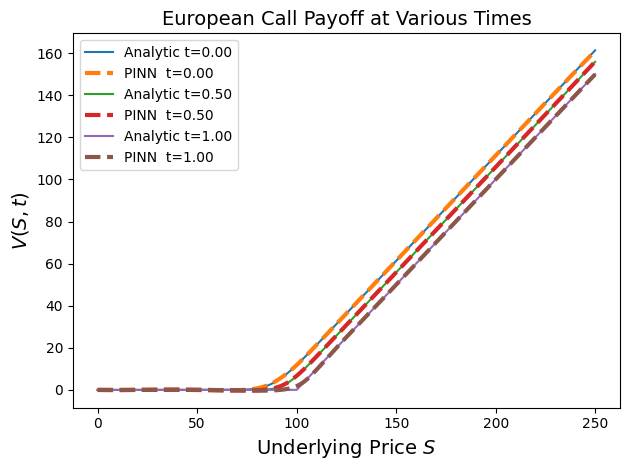

In [ ]:
t_list = [0.0, 0.5*T, T]

for t in t_list:
    # Make an array of the same shape as S_plot, filled with this t
    t_arr = t * np.ones_like(S_plot)              # shape (200,1)

    # Stack side‑by‑side: each row is [S_i, t]
    inp = np.hstack([S_plot, t_arr])              # shape (200,2)

    # Convert to torch.Tensor and run through the network
    with torch.no_grad():
        V_pinn = pinn(torch.tensor(inp, dtype=torch.float32)).numpy().flatten()

    # Compute analytic BS price at time t
    V_ex   = bs_call_analytic(S_plot.flatten(), t, K, r, sigma, T)

    # Plot both on the same axes
    plt.plot(S_plot, V_ex, label=f'Analytic t={t:.2f}')
    plt.plot(S_plot, V_pinn,'--', label=f'PINN  t={t:.2f}', linewidth=3)

plt.xlabel('Underlying Price $S$', fontsize=14)
plt.ylabel('$V(S,t)$', fontsize=14)
plt.title('European Call Payoff at Various Times', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

<ipython-input-46-9074c080f6b0>:7: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))


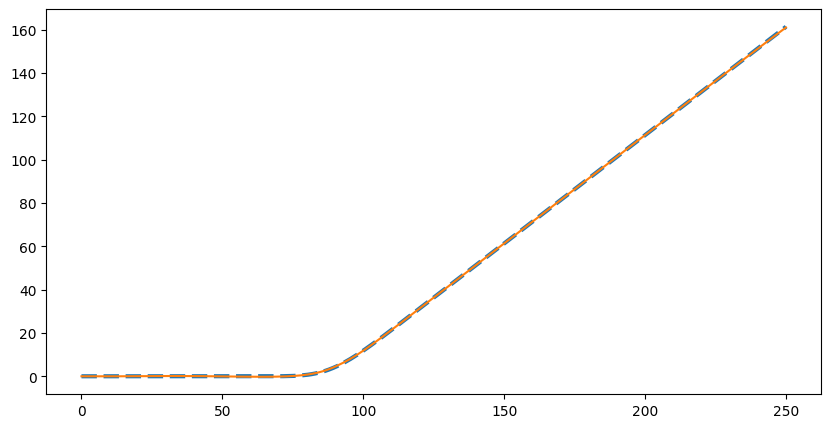

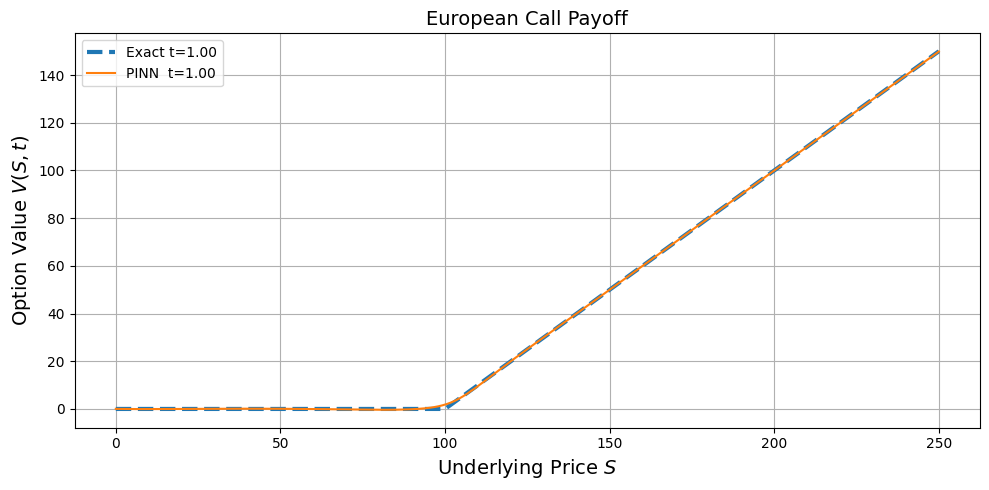

In [ ]:
t_list = [0, T]

for t in t_list:
    # Make an array of the same shape as S_plot, filled with this t
    t_arr = t * np.ones_like(S_plot)              # shape (200,1)

    # Stack side‑by‑side: each row is [S_i, t]
    inp = np.hstack([S_plot, t_arr])              # shape (200,2)

    # Convert to torch.Tensor and run through the network
    with torch.no_grad():
        V_pinn = pinn(torch.tensor(inp, dtype=torch.float32)).numpy().flatten()

    # Compute analytic BS price at time t
    V_ex   = bs_call_analytic(S_plot.flatten(), t, K, r, sigma, T)

    # Plot both on the same axes
    plt.figure(figsize=(10, 5))
    plt.plot(S_plot, V_ex,  '--', linewidth=3,  label=f'Exact t={t:.2f}')
    plt.plot(S_plot, V_pinn, '-' , label=f'PINN  t={t:.2f}')

plt.xlabel('Underlying Price $S$', fontsize=14)
plt.ylabel('Option Value $V(S,t)$', fontsize=14)
plt.title('European Call Payoff', fontsize=14)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

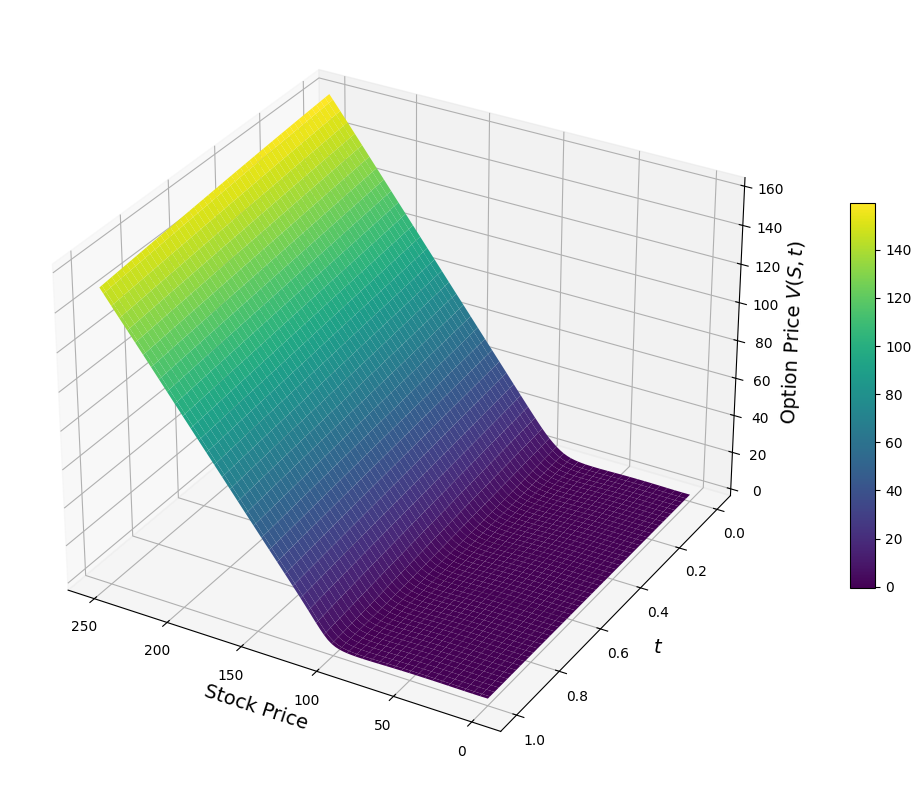

In [ ]:
Ns, Nt = 100, 100
S_vals = np.linspace(0, S_max, Ns)
t_vals = np.linspace(0, T, Nt)
S_mesh, t_mesh = np.meshgrid(S_vals, t_vals)

# 2) Evaluate PINN on the grid
inp = np.stack([S_mesh.flatten(), t_mesh.flatten()], axis=1)
with torch.no_grad():
    V_pred = pinn(torch.tensor(inp, dtype=torch.float32)).numpy().flatten()
V_mesh = V_pred.reshape(Nt, Ns)

# 3) Plot 3D surface
fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(
    S_mesh, t_mesh, V_mesh,
    cmap='viridis', edgecolor='none'
)
ax.set_xlabel('Stock Price', fontsize=14)
ax.set_ylabel('$t$', fontsize=14)
ax.set_zlabel('Option Price $V(S,t)$', fontsize=14)
#ax.set_title('PINN‐Predicted Option Price Surface', fontsize=14)
ax.view_init(elev=30, azim=120)
fig.colorbar(surf, shrink=0.5, aspect=15)
plt.show()

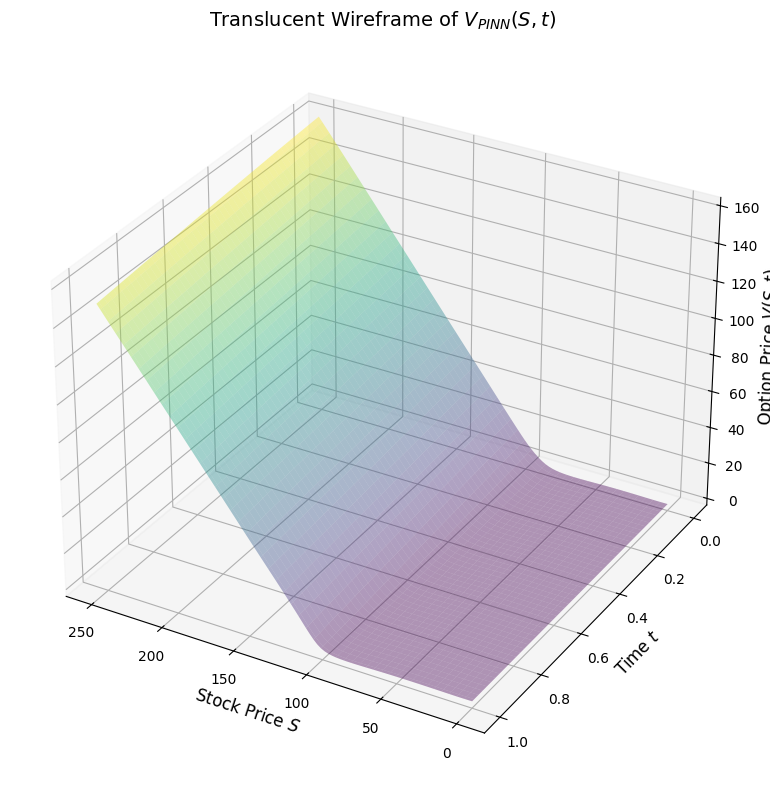

In [ ]:
# 1) Build your mesh
Ns, Nt = 100, 100
S_vals = np.linspace(0, S_max, Ns)
t_vals = np.linspace(0, T, Nt)
S_mesh, t_mesh = np.meshgrid(S_vals, t_vals)

# 2) Evaluate PINN
inp = np.stack([S_mesh.flatten(), t_mesh.flatten()], axis=1)
with torch.no_grad():
    V_pred = pinn(torch.tensor(inp, dtype=torch.float32)).numpy().flatten()
V_mesh = V_pred.reshape(Nt, Ns)

# 3) Plot translucent wireframe
fig = plt.figure(figsize=(12, 8))
ax  = fig.add_subplot(111, projection='3d')

# a) Optional: a faint surface underneath
ax.plot_surface(
    S_mesh, t_mesh, V_mesh,
    cmap='viridis',
    alpha=0.4,           # very faint surface
    edgecolor='none'
)

# b) Main: the wireframe
ax.plot_wireframe(
    S_mesh, t_mesh, V_mesh,
    rstride=5,           # row stride (every 5th line)
    cstride=5,           # column stride
    color='black',
    alpha=0.0            # translucency
)

ax.set_xlabel('Stock Price $S$', fontsize=12)
ax.set_ylabel('Time $t$', fontsize=12)
ax.set_zlabel('Option Price $V(S,t)$', fontsize=12)
ax.set_title('Translucent Wireframe of $V_{PINN}(S,t)$', fontsize=14)
ax.view_init(elev=30, azim=120)

plt.tight_layout()
plt.show()

<ipython-input-46-9074c080f6b0>:7: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))


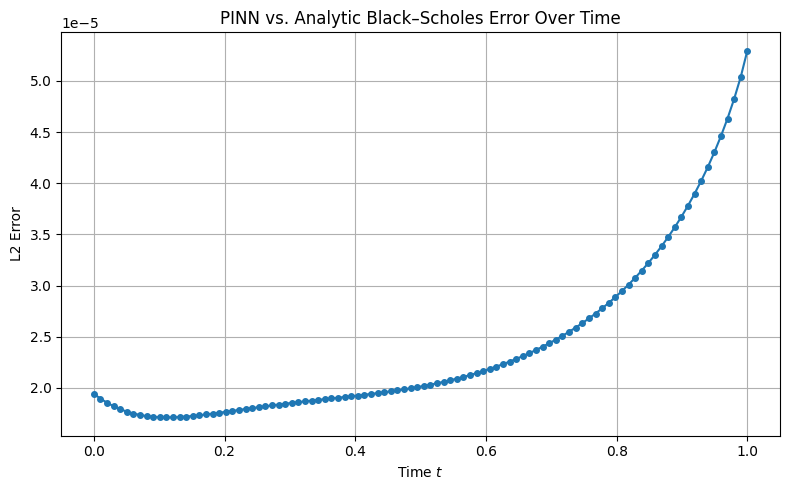

In [ ]:
S_plot = np.linspace(0, S_max, 2000)[:, None]

# 2) Choose time points to evaluate error
n_t = 100
t_seq = np.linspace(0, T, n_t)

errors = []
for t in t_seq:
    # Build input batch [S, t]
    t_arr = t * np.ones_like(S_plot)
    inp = np.hstack([S_plot, t_arr])

    # PINN prediction
    with torch.no_grad():
        V_pred = pinn(torch.tensor(inp, dtype=torch.float32)).numpy().flatten()

    # Exact solution
    V_ex = bs_call_analytic(S_plot.flatten(), t, K, r, sigma, T)

    # Compute L2 error over S
    l2_err = np.linalg.norm(V_pred - V_ex) * (1/(100*len(V_ex)))
    errors.append(l2_err)

# 3) Plot error vs time
plt.figure(figsize=(8,5))
plt.plot(t_seq, errors, '-o', markersize=4)
plt.xlabel('Time $t$')
plt.ylabel('L2 Error')
plt.title('PINN vs. Analytic Black–Scholes Error Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()